In [1]:
import os
import time
import os.path as osp

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms
import torchvision

import matplotlib.pyplot as plt
from PIL import Image

SEED = 1 
NUM_CLASS = 10
BATCH_SIZE = 128
NUM_EPOCHS = 30
EVAL_INTERVAL=1
SAVE_DIR = './log'
LEARNING_RATE = 1e-1
MOMENTUM = 0.9
STEP=5
GAMMA=0.5

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

transform_cifar10_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_cifar10_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_set = torchvision.datasets.CIFAR10(root='../data', train=True,
                                        download=True, transform=transform_cifar10_train)
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='../data', train=False,
                                       download=True, transform=transform_cifar10_test)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Files already downloaded and verified
Files already downloaded and verified


In [2]:
# MAE(L1) loss
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 4, 3)  
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(4, 8, 3)  
        self.fc1 = nn.Linear(8 * 6 * 6, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 8 * 6 * 6)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
model = ConvNet()
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

criterion = nn.L1Loss()

def train_batch(model, image, target):
    output = model(image)
    output = torch.max(output, dim=1)[1]
    output = output.float()
    target = target.float()
    loss = criterion(output, target)
    loss = torch.tensor(loss, requires_grad=True)
    output = model(image)  
    return output, loss

def test_batch(model, image, target):
    output = model(image) 
    output = torch.max(output, dim=1)[1]
    output = output.float()
    target = target.float()   
    loss = criterion(output, target)
    loss = torch.tensor(loss, requires_grad=True)
    output = model(image)
    return output, loss

training_loss = []
training_acc = []
testing_loss = []
testing_acc = []

list = []

for epoch in range(NUM_EPOCHS):
    model.train()
    torch.cuda.empty_cache()
    running_cls_loss = 0.0
    running_cls_corrects = 0
    for batch_idx, (image, target) in enumerate(train_dataloader):
        image = image.to(device)
        target = target.to(device)
        outputs, loss = train_batch(model, image, target)
        _, preds = torch.max(outputs, 1)
        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    epoch_loss = running_cls_loss / len(train_set)
    epoch_acc = running_cls_corrects.double() / len(train_set)
    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
    training_loss.append(epoch_loss)
    training_acc.append(epoch_acc.cpu().detach().numpy())
    scheduler.step()
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
        print('Begin test......')
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        for batch_idx, (image, target) in enumerate(test_dataloader):
            image = image.to(device)
            target = target.to(device)
            outputs, loss = test_batch(model, image, target)
            _, preds = torch.max(outputs, 1)
            val_loss += loss.item()
            val_corrects += torch.sum(preds == target.data)
        val_loss = val_loss / len(test_set)
        val_acc = val_corrects.double() / len(test_set)
        print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        list.append(val_acc)
        testing_loss.append(val_loss)
        testing_acc.append(val_acc.cpu().detach().numpy())
        if (epoch +1) == NUM_EPOCHS:  
            state = {
            'state_dict': model.state_dict(),
            'acc': epoch_acc,
            'epoch': (epoch+1),
            }
            if not os.path.exists(SAVE_DIR):
                os.makedirs(SAVE_DIR)
            torch.save(state, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))

MAE_L1_Acc = np.array([tensor.item() for tensor in list])
print(MAE_L1_Acc)

/tmp/ipykernel_40291/4218948423.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.tensor(loss, requires_grad=True)


Epoch: 1/30 Train Loss: 0.0228 Acc: 0.1158
Begin test......


/tmp/ipykernel_40291/4218948423.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.tensor(loss, requires_grad=True)


Test Loss: 0.0228 Acc: 0.1165
Epoch: 2/30 Train Loss: 0.0228 Acc: 0.1167
Begin test......
Test Loss: 0.0228 Acc: 0.1165
Epoch: 3/30 Train Loss: 0.0228 Acc: 0.1165
Begin test......
Test Loss: 0.0228 Acc: 0.1165
Epoch: 4/30 Train Loss: 0.0227 Acc: 0.1180
Begin test......
Test Loss: 0.0228 Acc: 0.1165
Epoch: 5/30 Train Loss: 0.0227 Acc: 0.1175
Begin test......
Test Loss: 0.0228 Acc: 0.1165
Epoch: 6/30 Train Loss: 0.0227 Acc: 0.1163
Begin test......
Test Loss: 0.0228 Acc: 0.1165
Epoch: 7/30 Train Loss: 0.0227 Acc: 0.1166
Begin test......
Test Loss: 0.0228 Acc: 0.1165
Epoch: 8/30 Train Loss: 0.0228 Acc: 0.1162
Begin test......
Test Loss: 0.0228 Acc: 0.1165
Epoch: 9/30 Train Loss: 0.0228 Acc: 0.1187
Begin test......
Test Loss: 0.0228 Acc: 0.1165
Epoch: 10/30 Train Loss: 0.0228 Acc: 0.1165
Begin test......
Test Loss: 0.0228 Acc: 0.1165
Epoch: 11/30 Train Loss: 0.0228 Acc: 0.1166
Begin test......
Test Loss: 0.0228 Acc: 0.1165
Epoch: 12/30 Train Loss: 0.0228 Acc: 0.1162
Begin test......
Test Lo

In [3]:
# CE loss
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 4, 3)  
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(4, 8, 3)  
        self.fc1 = nn.Linear(8 * 6 * 6, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 8 * 6 * 6)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
model = ConvNet()
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

criterion = nn.CrossEntropyLoss()

def train_batch(model, image, target):
    output = model(image)
    loss = criterion(output, target) 
    return output, loss

def test_batch(model, image, target):
    output = model(image)   
    loss = criterion(output, target)
    return output, loss

training_loss = []
training_acc = []
testing_loss = []
testing_acc = []

list = []

for epoch in range(NUM_EPOCHS):
    model.train()
    torch.cuda.empty_cache()
    running_cls_loss = 0.0
    running_cls_corrects = 0
    for batch_idx, (image, target) in enumerate(train_dataloader):
        image = image.to(device)
        target = target.to(device)
        outputs, loss = train_batch(model, image, target)
        _, preds = torch.max(outputs, 1)
        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    epoch_loss = running_cls_loss / len(train_set)
    epoch_acc = running_cls_corrects.double() / len(train_set)
    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
    training_loss.append(epoch_loss)
    training_acc.append(epoch_acc.cpu().detach().numpy())
    scheduler.step()
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
        print('Begin test......')
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        for batch_idx, (image, target) in enumerate(test_dataloader):
            image = image.to(device)
            target = target.to(device)
            outputs, loss = test_batch(model, image, target)
            _, preds = torch.max(outputs, 1)
            val_loss += loss.item()
            val_corrects += torch.sum(preds == target.data)
        val_loss = val_loss / len(test_set)
        val_acc = val_corrects.double() / len(test_set)
        print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        list.append(val_acc)
        testing_loss.append(val_loss)
        testing_acc.append(val_acc.cpu().detach().numpy())
        if (epoch +1) == NUM_EPOCHS:  
            state = {
            'state_dict': model.state_dict(),
            'acc': epoch_acc,
            'epoch': (epoch+1),
            }
            if not os.path.exists(SAVE_DIR):
                os.makedirs(SAVE_DIR)
            torch.save(state, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))

CE_Acc = np.array([tensor.item() for tensor in list])
print(CE_Acc)

Epoch: 1/30 Train Loss: 0.0151 Acc: 0.2823
Begin test......
Test Loss: 0.0139 Acc: 0.3649
Epoch: 2/30 Train Loss: 0.0139 Acc: 0.3421
Begin test......
Test Loss: 0.0139 Acc: 0.3691
Epoch: 3/30 Train Loss: 0.0137 Acc: 0.3577
Begin test......
Test Loss: 0.0129 Acc: 0.4074
Epoch: 4/30 Train Loss: 0.0135 Acc: 0.3726
Begin test......
Test Loss: 0.0129 Acc: 0.4136
Epoch: 5/30 Train Loss: 0.0136 Acc: 0.3677
Begin test......
Test Loss: 0.0126 Acc: 0.4042
Epoch: 6/30 Train Loss: 0.0125 Acc: 0.4229
Begin test......
Test Loss: 0.0117 Acc: 0.4625
Epoch: 7/30 Train Loss: 0.0122 Acc: 0.4326
Begin test......
Test Loss: 0.0112 Acc: 0.4936
Epoch: 8/30 Train Loss: 0.0121 Acc: 0.4418
Begin test......
Test Loss: 0.0116 Acc: 0.4734
Epoch: 9/30 Train Loss: 0.0120 Acc: 0.4506
Begin test......
Test Loss: 0.0113 Acc: 0.4889
Epoch: 10/30 Train Loss: 0.0120 Acc: 0.4497
Begin test......
Test Loss: 0.0114 Acc: 0.4902
Epoch: 11/30 Train Loss: 0.0114 Acc: 0.4806
Begin test......
Test Loss: 0.0107 Acc: 0.5186
Epoch: 1

In [4]:
# Focal loss (gamma=0.5)
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 4, 3)  
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(4, 8, 3)  
        self.fc1 = nn.Linear(8 * 6 * 6, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 8 * 6 * 6)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
model = ConvNet()
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

class FocalLoss(nn.Module):
    
    def __init__(self, gamma, alpha = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]):
        # 问题是10分类的，我们假设每个类别出现的次数无明显差异
        super(FocalLoss, self).__init__()
        self.alpha = torch.tensor(alpha)
        self.gamma = gamma
        
    def forward(self, output, target):
        # 注意这里的output是128*10的二维tensor，其实也没必要特别注意啦，一直都是一样的
        # 移到device上进行操作，避免报错
        alpha = self.alpha.to(device)
        alpha = alpha[target]
        log_softmax = torch.log_softmax(output, dim=1) # 对模型裸输出做softmax再取log, shape=(bs, 3)
        logpt = torch.gather(log_softmax, dim=1, index=target.view(-1, 1))  # 取出每个样本在类别标签位置的log_softmax值, shape=(bs, 1)
        logpt = logpt.view(-1)  # 降维，shape=(bs)
        ce_loss = -logpt  # 对log_softmax再取负，就是交叉熵了
        pt = torch.exp(logpt)  #对log_softmax取exp，把log消了，就是每个样本在类别标签位置的softmax值了，shape=(bs)
        focal_loss = alpha * (1 - pt) ** self.gamma * ce_loss  # 根据公式计算focal loss，得到每个样本的loss值，shape=(bs)
        return torch.mean(focal_loss)
    
criterion = FocalLoss(0.5)

def train_batch(model, image, target):
    output = model(image)
    loss = criterion(output, target) 
    return output, loss

def test_batch(model, image, target):
    output = model(image)   
    loss = criterion(output, target)
    return output, loss

training_loss = []
training_acc = []
testing_loss = []
testing_acc = []

list = []

for epoch in range(NUM_EPOCHS):
    model.train()
    torch.cuda.empty_cache()
    running_cls_loss = 0.0
    running_cls_corrects = 0
    for batch_idx, (image, target) in enumerate(train_dataloader):
        image = image.to(device)
        target = target.to(device)
        outputs, loss = train_batch(model, image, target)
        _, preds = torch.max(outputs, 1)
        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    epoch_loss = running_cls_loss / len(train_set)
    epoch_acc = running_cls_corrects.double() / len(train_set)
    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
    training_loss.append(epoch_loss)
    training_acc.append(epoch_acc.cpu().detach().numpy())
    scheduler.step()
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
        print('Begin test......')
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        for batch_idx, (image, target) in enumerate(test_dataloader):
            image = image.to(device)
            target = target.to(device)
            outputs, loss = test_batch(model, image, target)
            _, preds = torch.max(outputs, 1)
            val_loss += loss.item()
            val_corrects += torch.sum(preds == target.data)
        val_loss = val_loss / len(test_set)
        val_acc = val_corrects.double() / len(test_set)
        print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        list.append(val_acc)
        testing_loss.append(val_loss)
        testing_acc.append(val_acc.cpu().detach().numpy())
        if (epoch +1) == NUM_EPOCHS:  
            state = {
            'state_dict': model.state_dict(),
            'acc': epoch_acc,
            'epoch': (epoch+1),
            }
            if not os.path.exists(SAVE_DIR):
                os.makedirs(SAVE_DIR)
            torch.save(state, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))

Focal_gamma01 = np.array([tensor.item() for tensor in list])
print(Focal_gamma01)

Epoch: 1/30 Train Loss: 0.0014 Acc: 0.2751
Begin test......
Test Loss: 0.0012 Acc: 0.4067
Epoch: 18/30 Train Loss: 0.0009 Acc: 0.5431
Begin test......
Test Loss: 0.0008 Acc: 0.5816
Epoch: 19/30 Train Loss: 0.0009 Acc: 0.5417
Begin test......
Test Loss: 0.0008 Acc: 0.5834
Epoch: 20/30 Train Loss: 0.0009 Acc: 0.5440
Begin test......
Test Loss: 0.0008 Acc: 0.5818
Epoch: 21/30 Train Loss: 0.0009 Acc: 0.5495
Begin test......
Test Loss: 0.0008 Acc: 0.5828
Epoch: 22/30 Train Loss: 0.0009 Acc: 0.5503
Begin test......
Test Loss: 0.0008 Acc: 0.5856
Epoch: 23/30 Train Loss: 0.0009 Acc: 0.5497
Begin test......
Test Loss: 0.0008 Acc: 0.5853
Epoch: 24/30 Train Loss: 0.0009 Acc: 0.5500
Begin test......
Test Loss: 0.0008 Acc: 0.5877
Epoch: 25/30 Train Loss: 0.0009 Acc: 0.5517
Begin test......
Test Loss: 0.0008 Acc: 0.5875
Epoch: 26/30 Train Loss: 0.0009 Acc: 0.5532
Begin test......
Test Loss: 0.0008 Acc: 0.5891
Epoch: 27/30 Train Loss: 0.0009 Acc: 0.5516
Begin test......
Test Loss: 0.0008 Acc: 0.5901


In [5]:
# Focal loss (gamma=2)
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 4, 3)  
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(4, 8, 3)  
        self.fc1 = nn.Linear(8 * 6 * 6, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 8 * 6 * 6)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
model = ConvNet()
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

class FocalLoss(nn.Module):
    
    def __init__(self, gamma, alpha = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]):
        # 问题是10分类的，我们假设每个类别出现的次数无明显差异
        super(FocalLoss, self).__init__()
        self.alpha = torch.tensor(alpha)
        self.gamma = gamma
        
    def forward(self, output, target):
        # 注意这里的output是128*10的二维tensor，其实也没必要特别注意啦，一直都是一样的
        # 移到device上进行操作，避免报错
        alpha = self.alpha.to(device)
        alpha = alpha[target]
        log_softmax = torch.log_softmax(output, dim=1) # 对模型裸输出做softmax再取log, shape=(bs, 3)
        logpt = torch.gather(log_softmax, dim=1, index=target.view(-1, 1))  # 取出每个样本在类别标签位置的log_softmax值, shape=(bs, 1)
        logpt = logpt.view(-1)  # 降维，shape=(bs)
        ce_loss = -logpt  # 对log_softmax再取负，就是交叉熵了
        pt = torch.exp(logpt)  #对log_softmax取exp，把log消了，就是每个样本在类别标签位置的softmax值了，shape=(bs)
        focal_loss = alpha * (1 - pt) ** self.gamma * ce_loss  # 根据公式计算focal loss，得到每个样本的loss值，shape=(bs)
        return torch.mean(focal_loss)
    
criterion = FocalLoss(2)

def train_batch(model, image, target):
    output = model(image)
    loss = criterion(output, target) 
    return output, loss

def test_batch(model, image, target):
    output = model(image)   
    loss = criterion(output, target)
    return output, loss

training_loss = []
training_acc = []
testing_loss = []
testing_acc = []

list = []

for epoch in range(NUM_EPOCHS):
    model.train()
    torch.cuda.empty_cache()
    running_cls_loss = 0.0
    running_cls_corrects = 0
    for batch_idx, (image, target) in enumerate(train_dataloader):
        image = image.to(device)
        target = target.to(device)
        outputs, loss = train_batch(model, image, target)
        _, preds = torch.max(outputs, 1)
        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    epoch_loss = running_cls_loss / len(train_set)
    epoch_acc = running_cls_corrects.double() / len(train_set)
    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
    training_loss.append(epoch_loss)
    training_acc.append(epoch_acc.cpu().detach().numpy())
    scheduler.step()
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
        print('Begin test......')
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        for batch_idx, (image, target) in enumerate(test_dataloader):
            image = image.to(device)
            target = target.to(device)
            outputs, loss = test_batch(model, image, target)
            _, preds = torch.max(outputs, 1)
            val_loss += loss.item()
            val_corrects += torch.sum(preds == target.data)
        val_loss = val_loss / len(test_set)
        val_acc = val_corrects.double() / len(test_set)
        print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        list.append(val_acc)
        testing_loss.append(val_loss)
        testing_acc.append(val_acc.cpu().detach().numpy())
        if (epoch +1) == NUM_EPOCHS:  
            state = {
            'state_dict': model.state_dict(),
            'acc': epoch_acc,
            'epoch': (epoch+1),
            }
            if not os.path.exists(SAVE_DIR):
                os.makedirs(SAVE_DIR)
            torch.save(state, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))

Focal_gamma02 = np.array([tensor.item() for tensor in list])
print(Focal_gamma02)# Focal loss (gamma=2)
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 4, 3)  
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(4, 8, 3)  
        self.fc1 = nn.Linear(8 * 6 * 6, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 8 * 6 * 6)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
model = ConvNet()
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

class FocalLoss(nn.Module):
    
    def __init__(self, gamma, alpha = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]):
        # 问题是10分类的，假设每个类别出现的次数无明显差异
        super(FocalLoss, self).__init__()
        self.alpha = torch.tensor(alpha)
        self.gamma = gamma
        
    def forward(self, output, target):
        alpha = self.alpha.to(device)
        alpha = alpha[target]
        log_softmax = torch.log_softmax(output, dim=1) # 对模型裸输出做softmax再取log, shape=(bs, 3)
        logpt = torch.gather(log_softmax, dim=1, index=target.view(-1, 1))  # 取出每个样本在类别标签位置的log_softmax值, shape=(bs, 1)
        logpt = logpt.view(-1)  # 降维，shape=(bs)
        ce_loss = -logpt  # 对log_softmax再取负，就是交叉熵了
        pt = torch.exp(logpt)  #对log_softmax取exp，把log消了，就是每个样本在类别标签位置的softmax值了，shape=(bs)
        focal_loss = alpha * (1 - pt) ** self.gamma * ce_loss  # 根据公式计算focal loss，得到每个样本的loss值，shape=(bs)
        return torch.mean(focal_loss)
    
criterion = FocalLoss(2)

def train_batch(model, image, target):
    output = model(image)
    loss = criterion(output, target) 
    return output, loss

def test_batch(model, image, target):
    output = model(image)   
    loss = criterion(output, target)
    return output, loss

training_loss = []
training_acc = []
testing_loss = []
testing_acc = []

list = []

for epoch in range(NUM_EPOCHS):
    model.train()
    torch.cuda.empty_cache()
    running_cls_loss = 0.0
    running_cls_corrects = 0
    for batch_idx, (image, target) in enumerate(train_dataloader):
        image = image.to(device)
        target = target.to(device)
        outputs, loss = train_batch(model, image, target)
        _, preds = torch.max(outputs, 1)
        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    epoch_loss = running_cls_loss / len(train_set)
    epoch_acc = running_cls_corrects.double() / len(train_set)
    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
    training_loss.append(epoch_loss)
    training_acc.append(epoch_acc.cpu().detach().numpy())
    scheduler.step()
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
        print('Begin test......')
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        for batch_idx, (image, target) in enumerate(test_dataloader):
            image = image.to(device)
            target = target.to(device)
            outputs, loss = test_batch(model, image, target)
            _, preds = torch.max(outputs, 1)
            val_loss += loss.item()
            val_corrects += torch.sum(preds == target.data)
        val_loss = val_loss / len(test_set)
        val_acc = val_corrects.double() / len(test_set)
        print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        list.append(val_acc)
        testing_loss.append(val_loss)
        testing_acc.append(val_acc.cpu().detach().numpy())
        if (epoch +1) == NUM_EPOCHS:  
            state = {
            'state_dict': model.state_dict(),
            'acc': epoch_acc,
            'epoch': (epoch+1),
            }
            if not os.path.exists(SAVE_DIR):
                os.makedirs(SAVE_DIR)
            torch.save(state, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))

Focal_gamma02 = np.array([tensor.item() for tensor in list])
print(Focal_gamma02)

Epoch: 1/30 Train Loss: 0.0011 Acc: 0.2928
Begin test......
Test Loss: 0.0009 Acc: 0.4266
Epoch: 2/30 Train Loss: 0.0009 Acc: 0.4050
Begin test......
Test Loss: 0.0008 Acc: 0.4770
Epoch: 3/30 Train Loss: 0.0008 Acc: 0.4359
Begin test......
Test Loss: 0.0007 Acc: 0.4966
Epoch: 4/30 Train Loss: 0.0008 Acc: 0.4587
Begin test......
Test Loss: 0.0007 Acc: 0.5032
Epoch: 5/30 Train Loss: 0.0008 Acc: 0.4704
Begin test......
Test Loss: 0.0007 Acc: 0.5077
Epoch: 6/30 Train Loss: 0.0007 Acc: 0.4955
Begin test......
Test Loss: 0.0006 Acc: 0.5462
Epoch: 7/30 Train Loss: 0.0007 Acc: 0.5010
Begin test......
Test Loss: 0.0006 Acc: 0.5432
Epoch: 8/30 Train Loss: 0.0007 Acc: 0.5055
Begin test......
Test Loss: 0.0006 Acc: 0.5407
Epoch: 9/30 Train Loss: 0.0007 Acc: 0.5101
Begin test......
Test Loss: 0.0006 Acc: 0.5544
Epoch: 10/30 Train Loss: 0.0007 Acc: 0.5115
Begin test......
Test Loss: 0.0006 Acc: 0.5537
Epoch: 11/30 Train Loss: 0.0007 Acc: 0.5208
Begin test......
Test Loss: 0.0006 Acc: 0.5691
Epoch: 1

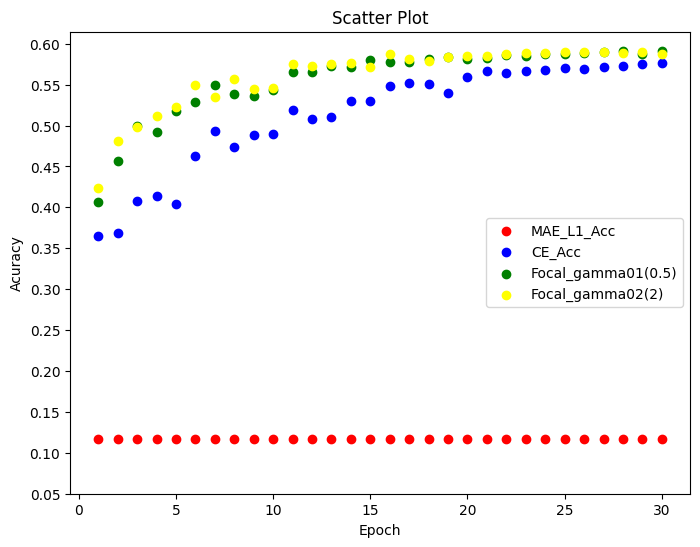

In [6]:
plt.figure(figsize=(8, 6))

x = torch.arange(1, 31)

plt.scatter(x, MAE_L1_Acc, color='red', label='MAE_L1_Acc')
plt.scatter(x, CE_Acc, color='blue', label='CE_Acc')
plt.scatter(x, Focal_gamma01, color='green', label='Focal_gamma01(0.5)')
plt.scatter(x, Focal_gamma02, color='yellow', label='Focal_gamma02(2)')

plt.title("Scatter Plot")
plt.xlabel("Epoch")
plt.ylabel("Acuracy")

plt.yticks(np.arange(0.05, 0.65, 0.05))

plt.legend()

plt.show()